In [1]:
#Reference taken from Github repo:https://github.com/NehaKoppikar/10daysofMLChallenge/blob/master/Day8_MulticlassClassification.ipynb

#the DataSet is :https://www.kaggle.com/cfpb/us-consumer-finance-complaints#consumer_complaints.csv

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
data = pd.read_csv('consumer_complaints.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

In [5]:
columns = ['product', 'consumer_complaint_narrative']

In [6]:
data = data[columns]

In [7]:
data = data.dropna(axis=0)
data = data.iloc[:5000, :]

In [8]:

data['category_id'] = data['product'].factorize()[0]
category_id_df = data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)
data.head()

,product,consumer_complaint_narrative,category_id
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
190207,Mortgage,I have an open and current mortgage with Chase...,2
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2


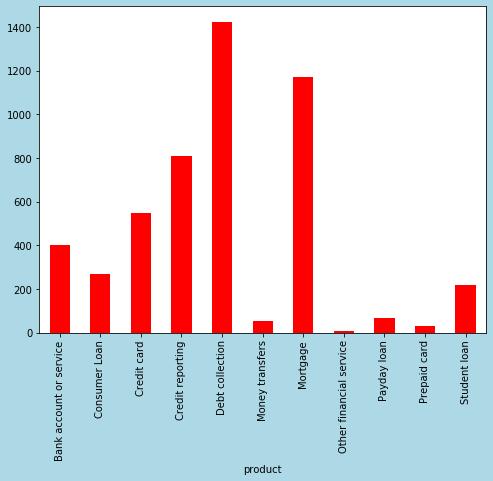

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6),facecolor='lightblue')
data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0,color='red')
plt.show()

In [18]:
def preprocessing(text):
    # punctuation marks 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  
    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")
            
    # Tokenization 
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text)
    
    # Removing stopwords
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    
    # Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    #Lemmatizing the text via wordnet_lemmatizer object created. 
    lemmatized_output = []
    for w in filtered_sentence:
        #pos tagging for a verb. Other options are noun and adjective
        lemma = wordnet_lemmatizer.lemmatize(w, pos='v')
        lemmatized_output.append(lemma)
                
    return lemmatized_output

In [19]:

def string_c(lst):
  lst = lst        
  return ' '.join(lst)

In [24]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
SENT_DETECTOR = nltk.data.load('tokenizers/punkt/english.pickle')
data['preprocessed'] = data['consumer_complaint_narrative'].apply(preprocessing,1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Archit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Archit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [25]:
data['preprocessed'] = data['preprocessed'].apply(string_c,1)
data['preprocessed']

190126    XXXX claim I owe 2700 XXXX years despite PROOF...
190135    Due inconsistencies amount owe I tell M T Bank...
190155    In XXXXXXXX wag I earn job decrease almost hal...
190207    I open current mortgage Chase Bank XXXX Chase ...
190208    XXXX submit XXXXXXXX At time I submit complain...
                                ...                        
218023    On I think Was approximately XXXXXXXX I get ca...
218024    I previously submit loan modification request ...
218025            I never receive notice debt right dispute
218027    The collection rep advise I able take apart pa...
218030    In 2007 exwife I XXXX I XXXX vehicles name For...
Name: preprocessed, Length: 5000, dtype: object

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data['consumer_complaint_narrative']).toarray()
labels = data['category_id']
features.shape

(5000, 13949)

In [27]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. branch
. overdraft
  . Most correlated bigrams:
. debit card
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. vehicle
. car
  . Most correlated bigrams:
. xxxx vehicle
. auto finance
# 'Credit card':
  . Most correlated unigrams:
. capital
. card
  . Most correlated bigrams:
. annual fee
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
. report xxxx
. credit report
# 'Debt collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. collect debt
. collection agency
# 'Money transfers':
  . Most correlated unigrams:
. wire
. paypal
  . Most correlated bigrams:
. money transfer
. wire transfer
# 'Mortgage':
  . Most correlated unigrams:
. modification
. mortgage
  . Most correlated bigrams:
. xxxx mortgage
. loan modification
# 'Other financial service':
  . Most correlated unigrams:
. guarantees
. dissatisfi

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed'], data['product'],test_size=0.3, random_state=9)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [31]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [32]:
from sklearn.naive_bayes import MultinomialNB

In [33]:
lf = MultinomialNB().fit(X_train_tfidf, y_train)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

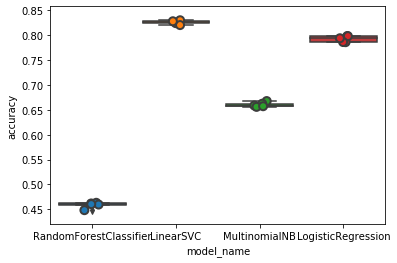

In [35]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [36]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.825799
LogisticRegression        0.792601
MultinomialNB             0.660393
RandomForestClassifier    0.458586
Name: accuracy, dtype: float64

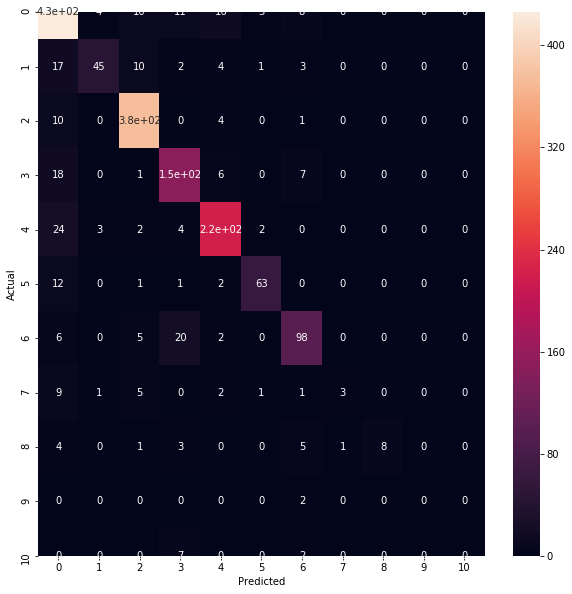

In [37]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [38]:
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['product', 'consumer_complaint_narrative']])
            print('')

'Consumer Loan' predicted as 'Debt collection' : 17 examples.


,product,consumer_complaint_narrative
217007,Consumer Loan,I have an installment from Check n Go for abou...
212747,Consumer Loan,Numerous phone calls at work even after I have...
206312,Consumer Loan,"Our auto loan company, Regional Acceptance Cor..."
210884,Consumer Loan,"unable to pay my loan to One Main Financial, i..."
212061,Consumer Loan,I have XXXX cases with you on the same conflic...
206619,Consumer Loan,I have an account with Westlake financial ( XX...
210914,Consumer Loan,"Last month, approx XXXX/XXXX/XXXX, I received ..."
211736,Consumer Loan,24 % interest rate high pmts refuses to help w...
197090,Consumer Loan,In XX/XX/2014 I purchased an Solar Air Cond. s...
203591,Consumer Loan,I had a car loan with Lobel Financial and beca...



'Mortgage' predicted as 'Debt collection' : 10 examples.


,product,consumer_complaint_narrative
201181,Mortgage,Upon receiving statements and other correspond...
202869,Mortgage,"SCAM ARTIST - Specialized Loan Servicing , LLC..."
216941,Mortgage,My parents house was forclosed on. By me being...
208439,Mortgage,Story enclosed in uploaded document sent to va...
210672,Mortgage,I made contact with Quicken Loans regarding a ...
216810,Mortgage,I had a loan with National City Bank and subse...
210125,Mortgage,I received notification that my loan was being...
206451,Mortgage,"This company, Select Portfolio Servicing , Inc..."
205548,Mortgage,I already have a case # XXXX and was told to r...
213729,Mortgage,"Contacted at my place of employment, by TD Ban..."



'Credit card' predicted as 'Debt collection' : 18 examples.


,product,consumer_complaint_narrative
200182,Credit card,I contracted with XXXX XXXX in XXXX of 2013 to...
197065,Credit card,This debt has been on my report for over 10 ye...
209324,Credit card,I XXXX XXXX paid XXXX creditor Capital ONe NAr...
214742,Credit card,I received a collection letter from First Nati...
214063,Credit card,I attempted to make a credit card payment for ...
210880,Credit card,When I found out about Servicemembers Civil Re...
211576,Credit card,Bank increased my interest rate far beyond my ...
205969,Credit card,I keep getting a robo call ( XXXX ) threatenin...
213034,Credit card,USAA did not follow procedures when they proce...
210260,Credit card,"I have used PayPal for years, with my charges ..."



'Credit reporting' predicted as 'Debt collection' : 24 examples.


,product,consumer_complaint_narrative
202861,Credit reporting,I had a dispute with XXXX over some overcharge...
203261,Credit reporting,TRIED TO OPEN BANK ACCOUNT AND XXXX SYSTEMS RE...
215739,Credit reporting,I recently received a credit report prior to a...
212534,Credit reporting,My divorce decree indicate that my ex wife to ...
212786,Credit reporting,"MY INSURANCE COMPANY, XXXX XXXX & XXXX XXXX SA..."
197095,Credit reporting,"I paid off my debt 100 % almost a year ago, ye..."
202876,Credit reporting,refused to send the report by email. the only ...
211380,Credit reporting,N/A account # XXXX This is inaccurate report a...
211589,Credit reporting,On XX/XX/XXXX myself and XXXX other roommates ...
207247,Credit reporting,You recently verified that XXXX items belong t...



'Student loan' predicted as 'Debt collection' : 12 examples.


,product,consumer_complaint_narrative
212043,Student loan,"XXXX XXXX, XXXX XXXX, and University XXXX XXXX..."
196265,Student loan,I have been in chapter XXXX since XX/XX/2011. ...
205308,Student loan,Was not contacted 4 years later about some pri...
211714,Student loan,I received a collection on my credit report in...
201894,Student loan,I have recently had a wage garnishment put in ...
209283,Student loan,"On XXXX XXXX, 2015 at approximately XXXX mount..."
209027,Student loan,"XXXX XXXX in XXXX, GA campus. I Spoke to this ..."
206257,Student loan,They keep calling even after I made payment. U...
205370,Student loan,This is a continuation of a previous issue wit...
213723,Student loan,"XXXX XXXX University in XXXX, Indiana is where..."



'Debt collection' predicted as 'Mortgage' : 10 examples.


,product,consumer_complaint_narrative
192077,Debt collection,The option I needed under false statements or ...
214696,Debt collection,In XXXX I have never had a late mortgage payme...
209634,Debt collection,My loan was sold to Central Mortgage in XXXX o...
216750,Debt collection,My account was reassigned to this company effe...
205233,Debt collection,Wells Fargo Bank reduced the obligation amount...
208999,Debt collection,GreetingsXXXX Company keeps trespassing on my ...
209649,Debt collection,"Please help me as a loan servicer, XXXX Mortga..."
200209,Debt collection,"My mortgage was sold to Nationstar Mortgage, t..."
216556,Debt collection,o My wife opened this account over XXXX years ...
208948,Debt collection,In XX/XX/XXXX I made a loan with HFC/Beneficia...



'Consumer Loan' predicted as 'Mortgage' : 10 examples.


,product,consumer_complaint_narrative
210442,Consumer Loan,During deployment turning in my SCRA documents...
214038,Consumer Loan,Applied for $ 50K HELOC from Wells Fargo on XX...
217891,Consumer Loan,I have a car loan through Fifth Third Bank in ...
208649,Consumer Loan,"In XXXX 2013, I was unable to pay the mortgage..."
211453,Consumer Loan,I took out a loan through Duvera Financial to ...
195549,Consumer Loan,Bank XXXX XXXX sent the payoff on XXXX trucks ...
215350,Consumer Loan,Santander came today to Reposes my XXXX after ...
214768,Consumer Loan,I have made my loan payment as agreed without ...
208079,Consumer Loan,1. XX/XX/2015 (? ) I cancelled autopay for XX/...
217856,Consumer Loan,Check out XXXXfor detailed descriptions on how...



'Debt collection' predicted as 'Credit card' : 11 examples.


,product,consumer_complaint_narrative
213195,Debt collection,I have a few Chase credit card account 's with...
213712,Debt collection,"I received the complaint sent by Care credit, ..."
209263,Debt collection,My mother ( who does not live with me and her ...
199324,Debt collection,The purported credit card debt that Chase Cred...
211355,Debt collection,FIA Card Services contacted me on behalf of Ba...
215731,Debt collection,I applied for a credit XXXX account with my si...
207760,Debt collection,I do not recognize this account as it was open...
217049,Debt collection,I had called the company when my husband had g...
207118,Debt collection,i do not recognize this information this is a ...
213567,Debt collection,This account has been paid. I contacted the or...



'Bank account or service' predicted as 'Credit card' : 20 examples.


,product,consumer_complaint_narrative
212567,Bank account or service,My Chase bank account ending in XXXX was close...
217552,Bank account or service,I inquired specifically regarding the ability ...
216001,Bank account or service,Sears representatives fraudulently processed a...
214243,Bank account or service,Was in XXXX XXXX XXXX XXXX in XX/XX/XXXX. Hosp...
214699,Bank account or service,"On XXXX XXXX, 2015 at around XXXX, I visited t..."
212495,Bank account or service,"on XXXX XXXX 2014 i, XXXX XXXX had my purse st..."
203275,Bank account or service,Explanation of complaint against PAYPAL Accoun...
213275,Bank account or service,I recently received a bulletin from my Financi...
212828,Bank account or service,"On XXXX XXXX, 2015 Citibank processed a charge..."
208591,Bank account or service,"I have a credit card with Capital One, a gm ca..."



'Debt collection' predicted as 'Credit reporting' : 16 examples.


,product,consumer_complaint_narrative
212973,Debt collection,I work all my life trying to do the best I can...
217604,Debt collection,"I received a letter and a phone call from "" HI..."
195124,Debt collection,an amount on my credit report which is not in ...
205828,Debt collection,"Year 1996 American Express sent letters, phone..."
208736,Debt collection,"When I was moving from XXXX to XXXX, I packed ..."
215407,Debt collection,I received my XXXX credit report and saw XXXX ...
211835,Debt collection,XXXX XXXX IS REPORTING FORECLOSURE AND JUDGEME...
213007,Debt collection,I originally signed up for XXXX service on XXX...
212441,Debt collection,I started looking in to buying a house last ye...
210953,Debt collection,I had my XXXX credit report done on me ... .an...


In [39]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . branch
  . Top bigrams:
       . debit card
       . checking account
# 'Consumer Loan':
  . Top unigrams:
       . vehicle
       . car
  . Top bigrams:
       . refused return
       . avant credit
# 'Credit card':
  . Top unigrams:
       . card
       . capital
  . Top bigrams:
       . credit card
       . synchrony bank
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . trans union
       . xxxx xxxx
# 'Debt collection':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . enhanced recovery
       . number called
# 'Money transfers':
  . Top unigrams:
       . transfer
       . scammed
  . Top bigrams:
       . wire transfer
       . money gram
# 'Mortgage':
  . Top unigrams:
       . mortgage
       . ocwen
  . Top bigrams:
       . loan modification
       . mortgage payment
# 'Other financial service':
  . Top unigrams:
       . regio

In [40]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=data['product'].unique()))

                         precision    recall  f1-score   support

        Debt collection       0.81      0.89      0.85       478
          Consumer Loan       0.85      0.55      0.67        82
               Mortgage       0.91      0.96      0.94       390
            Credit card       0.75      0.82      0.79       179
       Credit reporting       0.86      0.86      0.86       256
           Student loan       0.90      0.80      0.85        79
Bank account or service       0.77      0.75      0.76       131
            Payday loan       0.75      0.14      0.23        22
        Money transfers       1.00      0.36      0.53        22
Other financial service       0.00      0.00      0.00         2
           Prepaid card       0.00      0.00      0.00         9

               accuracy                           0.84      1650
              macro avg       0.69      0.56      0.59      1650
           weighted avg       0.84      0.84      0.83      1650



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
